[Source](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)

In [54]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
    
def plot_decision_boundary(X, y, pred_func):
    # Find the boundaries of the plot and give it some margin
    margin = 0.5
    x_min = X[:, 0].min() - margin
    x_max = X[:, 0].max() + margin
    y_min = X[:, 1].min() - margin
    y_max = X[:, 1].max() + margin
    step = 0.01
    # Generate a grid of points with some step size
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))    
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)    
    
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Generate a dataset and plot it
np.random.seed(100)
X_train, y_train = sklearn.datasets.make_moons(200, noise=0.20)

# X_train is a (200, 2) matrix
# y_train is a binary vector with 200 elements

print("Plot the dataset")
#plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)
#plt.show()

Plot the dataset


The model will be implemented as a neuronal network with one hidden layer.

Forward pass:

$$
z_1 = xW_1 + b_1 \\
a_1 = tanh(z_1) \\
z_2 = a_1W_2 + b_2 \\
a2 = \hat y = softmax(z_2)
$$

$W_1, b_1, W_2, b_2$ are parameters of the model that we need to learn. The parameters are learned by minimizing a loss function. A usual choice for the softmax output is the **categorical cross-entropy loss**:

$$ L(y, \hat y) = -\frac1N \sum_{i=1}^n \sum_{j=1}^m y_{ij} log(\hat y_{ij})$$

n: number of examples<br>
m: number of classes<br>
$y_i$: true label of sample $x_i$, 1-hot vector<br>
$\hat y_{i} \in (0,1)$: vector with predictions for $x_i$, $ \sum_j \hat y_{ij} = 1$

We use **gradient descent** to find parameters that minimize the loss function. 

For gradient descent we need the partial gradients of the loss function: $ \frac{\partial L}{\partial W1}, \frac{\partial L}{\partial b1}, \frac{\partial L}{\partial W2}, \frac{\partial L}{\partial b2} $

The gradients are calculated using **backpropagation**.

Applying the backpropagation algorithm we find the following:

$$
\partial_3 = \hat y - y \\
\partial_2 = (1- tanh^2(z_1)) \circ \partial_3 W_2^T \\
\frac{\partial L}{\partial W_2} = a_1^T \partial_3
\frac{\partial L}{\partial b_2} = \partial_3 \\
\frac{\partial L}{\partial W_1} = x_T \partial_2 \\
\frac{\partial L}{\partial b_1} = \partial_2 \\
$$

In [35]:
num_examples = len(X_train) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
 
# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength


In [44]:
def calculate_loss(X, y, model):
    ''' evaluate the total loss on the dataset '''
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2  # a (nb_examples, nb_classes) matrix 
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [50]:
# Helper function to predict an output (0 or 1)
def predict(X, model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [45]:
def build_model(X, y, nn_hdim, num_passes=20000, print_loss=False):
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(X, y, model)))
     
    return model
        

In [46]:
# Build a model with a 3-dimensional hidden layer
model = build_model(X_train, y_train, 3, print_loss=True)

Loss after iteration 0: 0.425794
Loss after iteration 1000: 0.042413
Loss after iteration 2000: 0.040681
Loss after iteration 3000: 0.040155
Loss after iteration 4000: 0.039905
Loss after iteration 5000: 0.039754
Loss after iteration 6000: 0.039651
Loss after iteration 7000: 0.039575
Loss after iteration 8000: 0.039517
Loss after iteration 9000: 0.039471
Loss after iteration 10000: 0.039434
Loss after iteration 11000: 0.039404
Loss after iteration 12000: 0.039380
Loss after iteration 13000: 0.039360
Loss after iteration 14000: 0.039344
Loss after iteration 15000: 0.039330
Loss after iteration 16000: 0.039319
Loss after iteration 17000: 0.039310
Loss after iteration 18000: 0.039302
Loss after iteration 19000: 0.039295


In [59]:
y_pred = predict(X_train, model)

In [60]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_train, y_pred)
print("Accuracy: {}".format(acc))

Accuracy: 0.985


In [61]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
confusion_matrix = pd.crosstab(y_train, y_pred, rownames=['True'], colnames=['Predicted'], margins=False)
print(confusion_matrix)


Confusion matrix:
Predicted   0   1
True             
0          99   1
1           2  98


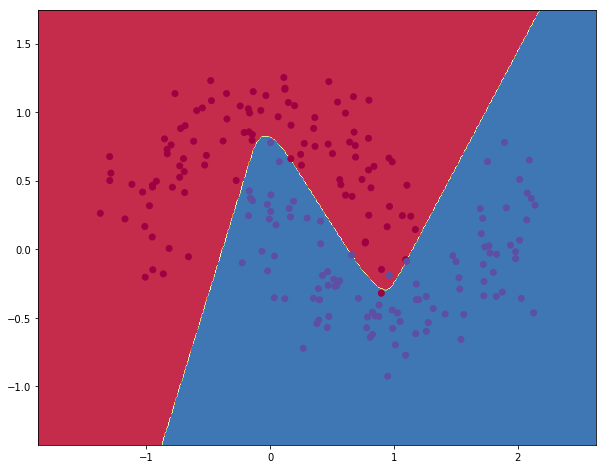

In [64]:

predict_fn = lambda x: predict(x, model)
plot_decision_boundary(X_train, y_train, predict_fn)